In [1]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

import re
import string
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics

from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline as make_pipeline_imb
# RandomOverStampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

import pandas_profiling

from train import *

np.random.seed(42)

%matplotlib inline

/home/han/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/han/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/han/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/han/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarnin

In [2]:
def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    target_names = labels
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    labels = data_selecteds.cat.unique()
    print('accuracy %s' % metrics.accuracy_score(target, predictions))
    cm = metrics.confusion_matrix(target, predictions, labels=labels)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, labels, title + ' Normalized')
    
def predict(X, y, classifier):
    predictions = classifier.predict(X)
    evaluate_prediction(predictions, y)
    return predictions

In [3]:
import os, platform, subprocess, re
command = "cat /proc/cpuinfo"
all_info = subprocess.check_output(command, shell=True).strip()
for line in all_info.split(b"\n"):
    if b"model name" in line:
        print(re.sub( ".*model name.*:", "", line.decode(),1))

 AMD PRO A6-9500B R5, 6 COMPUTE CORES 2C+4G
 AMD PRO A6-9500B R5, 6 COMPUTE CORES 2C+4G


# Explore data

In [4]:
data = pd.read_csv('data/reddit.csv')

In [5]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163897 entries, 0 to 163896
Data columns (total 3 columns):
title    163897 non-null object
url      163897 non-null object
cat      163897 non-null object
dtypes: object(3)
memory usage: 3.8+ MB


,title,url,cat
count,163897,163897,163897
unique,162590,163897,110
top,New Clojurians: Ask Anything,/r/Life/comments/9hjtxm/anyone_else_feel_like_...,computer_sound
freq,23,1,2890


In [6]:
data.head()

,title,url,cat
0,I feel like I'm losing it...,/r/Life/comments/cd00hw/i_feel_like_im_losing_it/,life
1,This is why I dont blame people for crime.,/r/Life/comments/cct84q/this_is_why_i_dont_bla...,life
2,HELP,/r/Life/comments/ccwlyz/help/,life
3,just a bookmark,/r/Life/comments/ccxkxz/just_a_bookmark/,life
4,Persevering and Overcoming Challenges,/r/Life/comments/ccsw5q/persevering_and_overco...,life


In [7]:
data.cat.values, data.cat.value_counts()

(array(['life', 'life', 'life', ..., 'programming_tools',
        'programming_tools', 'programming_tools'], dtype=object),
 computer_sound    2890
 raspberry_pi      2083
 politics          2061
 gamedev           1938
 scifi             1937
                   ... 
 csbook             435
 tcl                261
 sml                164
 unikernel          121
 causality           15
 Name: cat, Length: 110, dtype: int64)

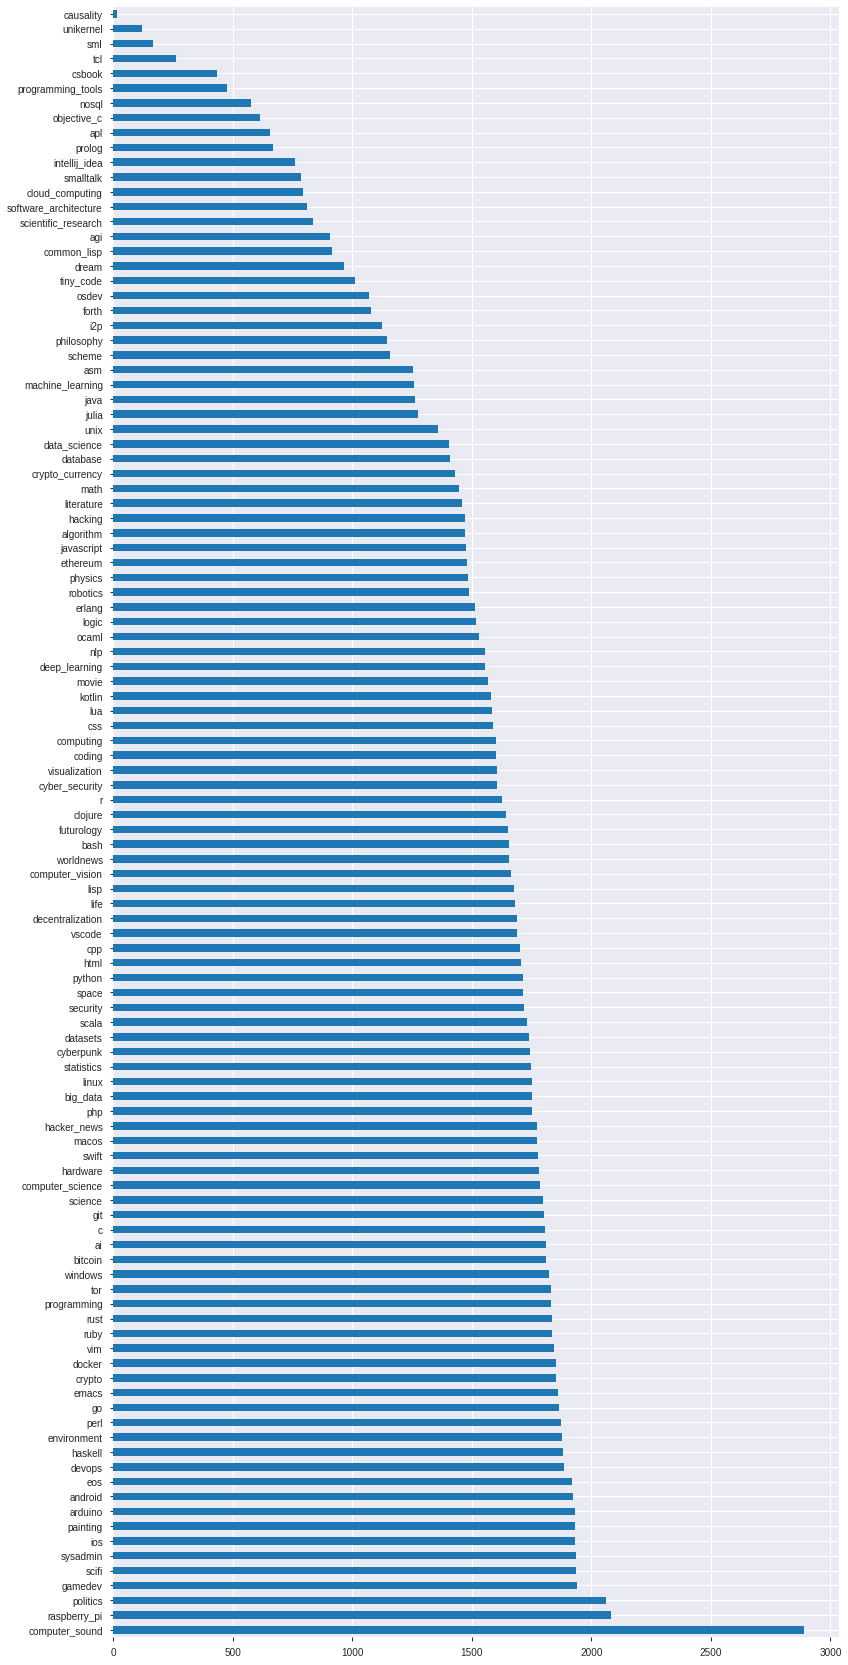

In [8]:
data.cat.value_counts().plot(kind='barh', figsize=(13, 30))

In [9]:
data.profile_report(style={'full_width':True})

# Reduce cats

In [9]:
cnts = data.cat.value_counts()
# acc: 0.62
data_selecteds = data[~data.cat.isin(cnts[(cnts < 1200) | (cnts > 1800)].index)].reset_index(drop=True)
# acc: 0.59
# data_selecteds = data[~data.cat.isin(cnts[(cnts < 500) | (cnts > 2000)].index)].reset_index(drop=True)

In [10]:
def merge_cats(cat):
    cat_map = dict(
        worldnews=['politics', 'environment'],
        science=['space', 'physics', 'philosophy', 'scientific_research', 'futurology'],
        computer_science=['computing', 'math', 'algorithm', 'logic', 'tiny_code', 
                          'software_architecture', 'decentralization', 'csbook'],
        machine_learning=['causality', 'data_science', 'statistics', 'big_data', 
                          'deep_learning', 'computer_sound', 'nlp', 'computer_vision', 
                          'datasets', 'ai', 'agi', 'robotics'],
        programming=['gamedev', 'coding'],
        programming_tools=['vim', 'emacs', 'vscode', 'intellij_idea', 'git'],
        programming_language=['forth', 'sml', 'tcl', 'objective_c', 'apl', 'prolog', 'smalltalk'],
        art=['literature', 'scifi', 'music', 'painting', 'dream', 'movie'],
        hardware=['raspberry_pi', 'arduino', ],
        devops=['sysadmin', 'docker', 'cloud_computing'],
        mobile=['ios', 'android'],
        os=['linux', 'unix', 'macos', 'windows', 'osdev', 'unikernel'],
        lisp=['scheme', 'clojure', 'common_lisp'],
        crypto=['eos', 'tor', 'i2p', 'bitcoin', 'crypto_currency', 'ethereum'],
        security=['cyberpunk', 'cyber_security', 'hacking'],
        database=['nosql'],
        other=['life'],
    )
    # see in confusion matrix for above cats predicts, add below:
    cat_map['devops'].extend(['go'])
    cat_map['machine_learning'].extend(['visualization'])
    cat_map['html'] = ['css']
    cat_map['mobile'].extend(['swift'])
    del cat_map['programming']
    del cat_map['computer_science']
    cat_map['algorithm'] = ['math', 'logic']
    cat_map['cpp'] = ['c']
    cat_map['os'].extend(['bash'])
    cat_map['art'].extend(['life'])
    del cat_map['other']
    cat_map['database'].extend(['decentralization'])
    
    for k, v in cat_map.items():
        if cat in v:
            return k
    return cat

# acc: 0.65
data_selecteds = data[data.cat != 'hacker_news'].reset_index(drop=True)
# see in confusion matrix for above cats predicts, add below:
data_selecteds = data_selecteds[~data_selecteds.cat.isin(
    ['computing', 'tiny_code', 'csbook', 'coding', 'programming', 'computer_science', 'software_architecture'])].reset_index(drop=True)

data_selecteds.cat = data_selecteds.cat.map(merge_cats)

# undersample reduced acc
# idxs = []
# for cat, cnt in data_selecteds.cat.value_counts().items():
#     idxs.extend(np.random.permutation(np.squeeze(np.argwhere(data_selecteds.cat == cat)))[:1250])
# data_selecteds = data_selecteds.loc[idxs].reset_index(drop=True)

data_selecteds.cat.value_counts()

machine_learning        21385
crypto                  11442
os                       9550
art                      9540
science                  8624
programming_tools        8430
devops                   8331
security                 6539
hardware                 5793
mobile                   5631
worldnews                5594
lisp                     5394
algorithm                4434
programming_language     4228
database                 3671
cpp                      3507
html                     3295
gamedev                  1938
haskell                  1881
perl                     1872
ruby                     1836
rust                     1834
php                      1753
scala                    1732
python                   1714
r                        1624
lua                      1586
kotlin                   1581
ocaml                    1529
erlang                   1515
javascript               1477
julia                    1275
java                     1263
asm       

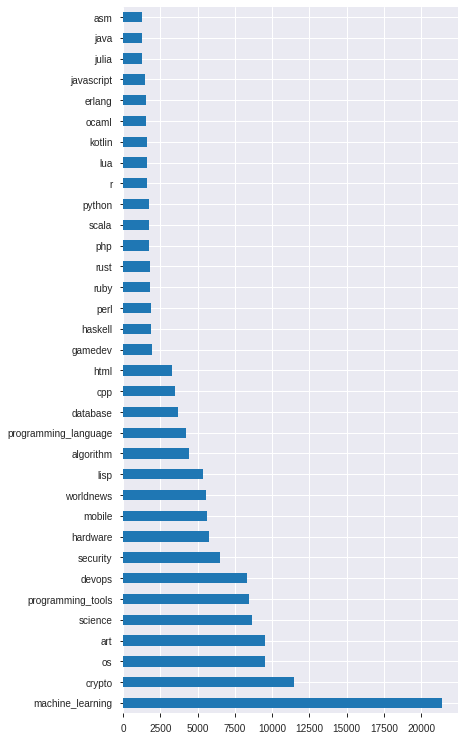

In [11]:
data_selecteds.cat.value_counts().plot(kind='barh', figsize=(6, 13))

In [12]:
len(data_selecteds.cat.unique())

34

# Clean data
Did not have much effects on train and test accuracy, code removed.

# Select features 
Did not have much effects on train and test accuracy, code removed.

# Pipline

In [13]:
_X_train, _X_test, _y_train, _y_test = train_test_split(data_selecteds.title, data_selecteds.cat, test_size=0.1)

In [14]:
resample = False
# why resample with pipline drop acc?
resample_pipline = False
# acc: 0.66
# ros = RandomOverSampler(random_state=0)
# acc: 0.73
# ros = ADASYN()
# acc: 0.76
ros = SMOTE()
# acc: 0.65
# ros = RandomUnderSampler()

In [15]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
feat_select = SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))

In [16]:
if resample and not resample_pipline:
    preds = TextClearner().fit(_X_train)
    tmp = preds.transform(_X_train)
    tv = tfidf_vector.fit(tmp)
    tmp = tv.transform(tmp)

In [17]:
if resample and not resample_pipline:
    X_train, y_train = ros.fit_resample(tmp, _y_train)
else:
    X_train, y_train = _X_train, _y_train

In [18]:
if resample and not resample_pipline:
    tmp = preds.transform(_X_test)
    tmp = tv.transform(tmp)

In [19]:
if resample and not resample_pipline:
    X_test, y_test = ros.fit_resample(tmp, _y_test)
else:
    X_test, y_test = _X_test, _y_test

In [20]:
# TODO: use hyperparameter-hunter to manage experiments

# classifier = BernoulliNB(alpha=.01)
# classifier = ComplementNB(alpha=1)
# classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# classifier = SGDClassifier(n_jobs=-1, max_iter=10)
# acc: 0.71, high recall: 0.72
classifier = LinearSVC(class_weight='balanced', max_iter=1000)
# classifier = LinearSVC(max_iter=1000)
# acc: 0.686, low recall: 0.65
# with SMOTE resample: acc: 0.73, recall: 0.73, but val/test(without resample) acc is low: 0.63

if resample:
    if not resample_pipline:
        classifier.fit(X_train, y_train)
    else:
        pipe = make_pipeline_imb(TextCleaner(),
                                 tfidf_vector,
                                 ros,
                                 classifier)
        pipe.fit(X_train,y_train)
else:
    pipe = Pipeline([("cleaner", TextCleaner()),
                     ('vectorizer', tfidf_vector),
                     # ('feat_select', model_vector),
                     ('classifier', classifier)])

    pipe.fit(X_train,y_train)

accuracy 0.7098523454854305
confusion matrix
 [[759  18  39 ...   2   1   2]
 [ 12 466  39 ...   0   0   1]
 [ 29  45 607 ...   1   7   3]
 ...
 [  3   1   1 ...  94   4   6]
 [  5   1   1 ...   5 247   7]
 [  7   5   0 ...  15  19 581]]
(row=expected, col=predicted)
Accuracy: 0.7098523454854305
Precision: 0.6643358335727636
Recall: 0.7135729374227037


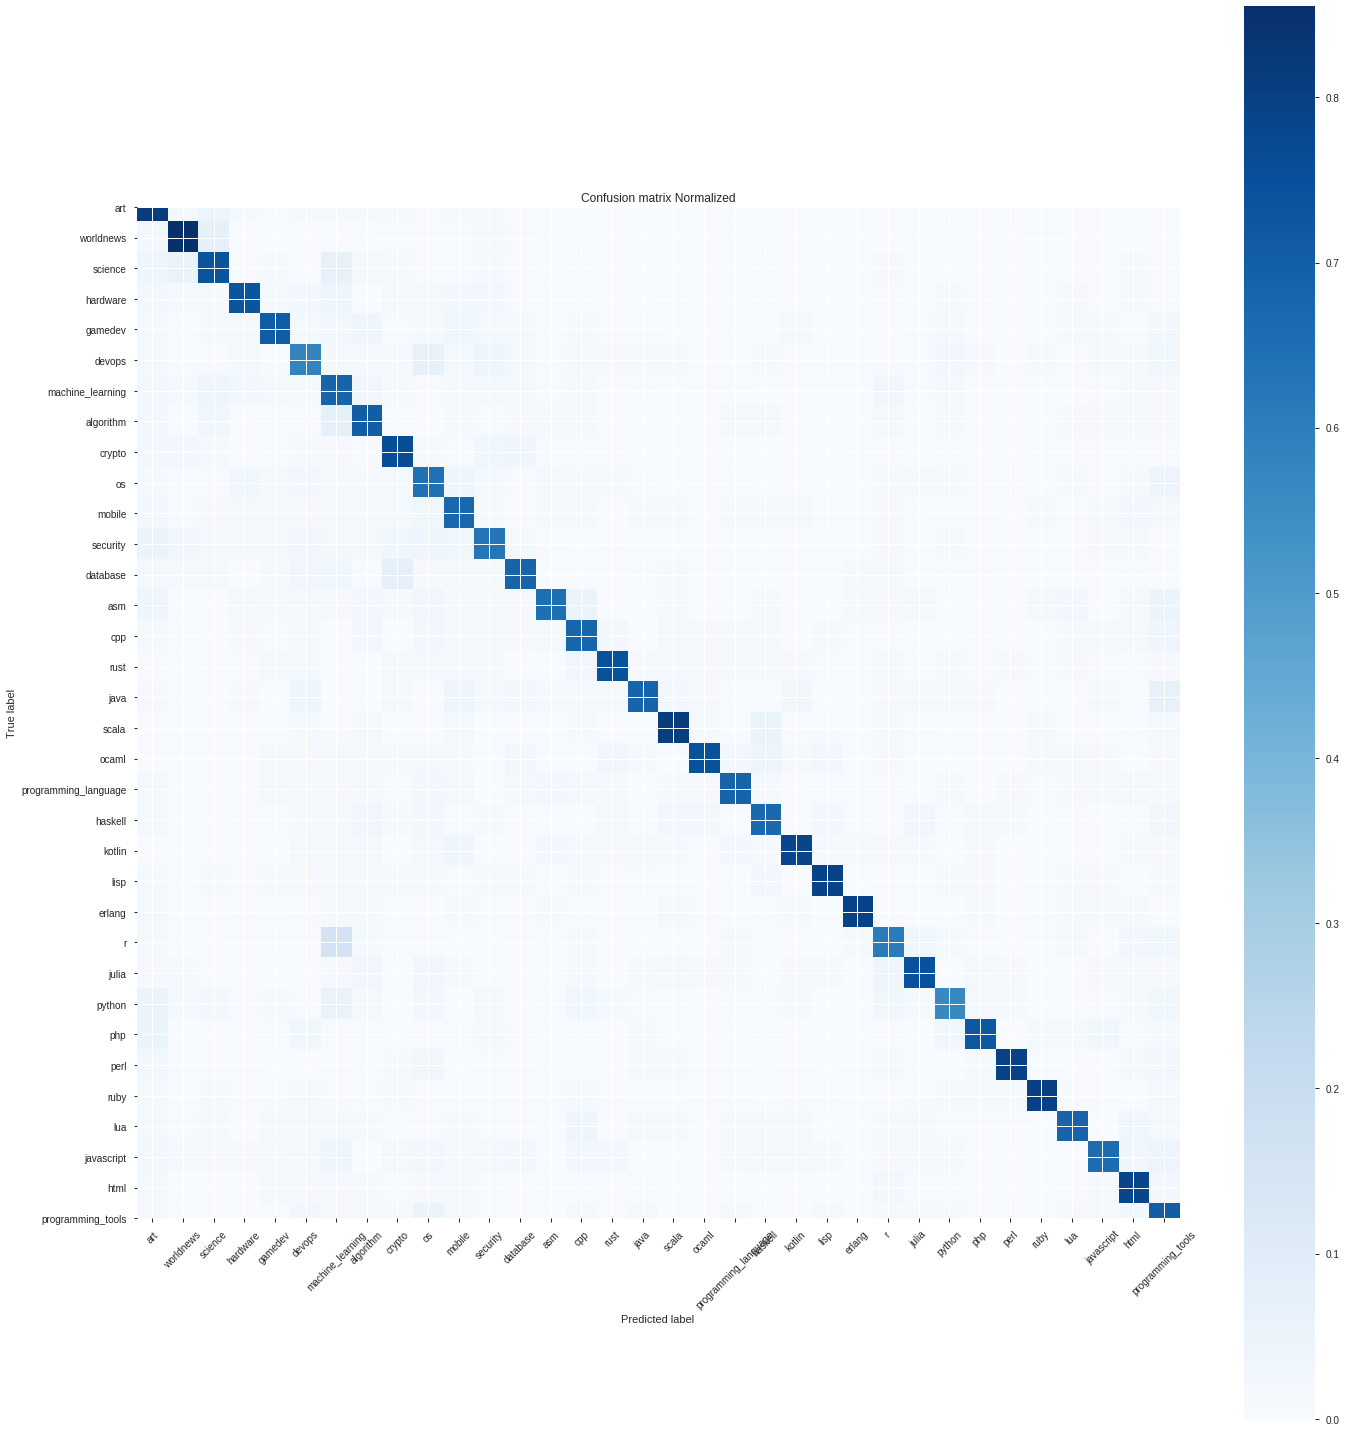

In [21]:
if resample:
    if not resample_pipline:
        predicted = classifier.predict(X_test)
    else:
        predicted = pipe.predict(X_test)
#     print(classification_report_imbalanced(y_test, y_pred))
else:
#     predicted = pipe.predict(X_test)
    predicted = predict(X_test, y_test, pipe)

print("Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Precision:", metrics.precision_score(y_test, predicted, average='macro'))
print("Recall:", metrics.recall_score(y_test, predicted, average='macro'))

In [22]:
X_pred = ['dfs: depth first search',
          'How SAML 2.0 Authentication Works',
          'What are the “best” codebases that you\'ve encountered?',
          'Book Review: Designing Data-Intensive Applications',
          'Some things that might help you make better software',
          'B-threads: programming in a way that allows for easier changes',
          'Browser extensions are underrated: the promise of hackable software',
          'Levels of code in Forth programming (2002)',
          'encode/decode gpt network',
          'it is not safe for software deploy',
          'learning web coding in scheme',
          'web code in nodejs',
          'luajit embed in c',
          'Dwindling CPAN Releases',
          'LightSail 2 Spacecraft Successfully Demonstrates Flight by Light',
          'Tokyo\'s audiophile venues ',
          'Composing better emails',
          'Alarming surge in drug-resistant HIV uncovered ',
          'LF: Fully Decentralized Fully Replicated Key/Value Store',
          'Hawaii Extends Thirty Meter Telescope Permit Amid Protests',
          'Show HN: Generate a fake app to replace any addictive app',
          'Most internet service providers are gone – Sonic has survived and thrived',
          'A Brief Guide to a Few Algebraic Structures ',
          'Implementing Poincaré Embeddings (2017)',
          'Launch HN: Hatchways (YC S19) – Internships Instead of Interviews',
          'The Enduring Mystery of ‘Jawn,’ Philadelphia’s All-Purpose Noun (2016) ',
          'Programming Algorithms: A Crash Course in Lisp',
          'A New York Farm Stand’s Success: An Eye for the Next Big Thing',
          'Music Recommendations in Hyperbolic Space',
          'The Ethics of Web Performance',
          'ThorShield Energy Weapon Protection Fabric',
          'ZRNA – Software-defined analog circuits',
          'Equifax removed the $125 claim payout option after millions submitted claims ',
          'Marvin Minsky and the Ultimate Tinker Toy ',
          'Filling hospitals with art reduces patient stress, anxiety and pain',
          'Actalis: Insufficient Serial Number Entropy ',
          'The Paradox of Toil (2010) ',
          'A Raspberry Pi-powered live train station sign ',
          'The Law Isn\'t Ready for Psychedelic Medicine',
          'A Transparent Display with Per-Pixel Color and Opacity Control',
          'Cortex – An ML model deployment platform that runs in your AWS account',
          'Plastic bag sales in England halved in past year',
          'A Look at Overnight Stays at US National Parks',
          'John Carmack on Parallel Implementations',
          'Knuth on Huang\'s Sensitivity Proof: “I\'ve got the proof down to one page” [pdf]',
          'A Readable Specification of TLS 1.3',
          'Ray tracing with uLisp',
          'Big O Notation – Using not-boring math to measure code’s efficiency ',
          'Solving differential equations on a 6502 with Woz\'s floating point code',
          'Machine Learning That’s Light Enough for an Arduino',
          'Detailed 3D map of Milky Way shows \'warped\' shape ',
          'GNU C Library 2.30',
          'A holographic view of a vertical plane, equally familiar and fulfilling in the first and final destination was the image of Jeremy and the countdown clock that had appeared in the hologram of the first moon orbiting above New Earth. “',
          'Contributing to the Mozilla code base',
          'A recurrent neural network for generating little stories about images',
          'Building a Programming Language Pt. 3 – Interpreting',
          'The Real Dark Web',
          'Things Reacters do that Re-framers avoid',
          'Low-level is easy (2008) ',
          'Standard Ebooks: Free public-domain ebooks, carefully produced ',
          'Living Near Trees, Not Just Green Space, Improves Wellbeing',
         ]
if resample:
    tmp = preds.transform(X_pred)
    tmp = tv.transform(tmp)
    for i, v in enumerate(classifier.predict(tmp)):
        print('(%s)' % v, X_pred[i])
else:
    for i, v in enumerate(pipe.predict(X_pred)):
        print('(%s)' % v, X_pred[i])


(algorithm) dfs: depth first search
(devops) How SAML 2.0 Authentication Works
(cpp) What are the “best” codebases that you've encountered?
(machine_learning) Book Review: Designing Data-Intensive Applications
(os) Some things that might help you make better software
(mobile) B-threads: programming in a way that allows for easier changes
(programming_tools) Browser extensions are underrated: the promise of hackable software
(programming_language) Levels of code in Forth programming (2002)
(security) encode/decode gpt network
(security) it is not safe for software deploy
(lisp) learning web coding in scheme
(javascript) web code in nodejs
(lua) luajit embed in c
(perl) Dwindling CPAN Releases
(science) LightSail 2 Spacecraft Successfully Demonstrates Flight by Light
(security) Tokyo's audiophile venues 
(ocaml) Composing better emails
(science) Alarming surge in drug-resistant HIV uncovered 
(database) LF: Fully Decentralized Fully Replicated Key/Value Store
(worldnews) Hawaii Extends T

In [23]:
# https://cmry.github.io/notes/serialize
# https://cmry.github.io/notes/serialize-sk

pkl_filename = "data/%s_model.pkl" % classifier.__class__.__name__
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)
    
with open(pkl_filename, 'rb') as file:
    pipe = pickle.load(file)
    
pipe.predict(['dfs: depth first search'])

array(['algorithm'], dtype=object)